In [1]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
import numpy as np
import plotly.graph_objects as go
# from config p key

In [2]:
org = "Artinus"
url = "https://eastus-1.azure.cloud2.influxdata.com"
token = "l7mZ63vVVzgUKP2z6_XMnZWKKJ4VNEeA6hSMPbqj_-z2l86OpSV8RA9EMzwoTPZSgg9KZzA8R6AkwztiBHgT6A=="

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

# OHLC Query

In [3]:
def get_ohlc(client, bucket, time_start, time_stop, symbol):
    query_api = client.query_api()
    varss = ['open', 'high','low', 'close']
    df_ohlc = pd.DataFrame(columns=varss)
    for var in varss:
        query = f"""
            from(bucket: "{bucket}")
            |> range(start: {time_start}, stop: {time_stop})
            |> filter(fn: (r) => r._measurement == "bid_{var}")
            |> filter(fn: (r) => r.symbol == "{symbol}")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
            |> map(fn: (r) => ({{r with {var}: r.price}}))
            """
        tables = query_api.query(query, org=org)
        df_var = query_api.query_data_frame(query, org=org)
        df_ohlc[var] = df_var[var]
    df_ohlc['_time'] = df_var['_time']
    df_ohlc['symbol'] = df_var['symbol']
    return df_ohlc

In [4]:
bucket = 'DukascopyTest'
time_start = '2022-08-09T17:14:06.790Z'
time_stop = '2022-08-10T17:14:06.790Z'
symbol = 'EUR/USD'
df_ohlc = get_ohlc(client, bucket, time_start, time_stop, symbol)
display(df_ohlc)

open     high      low    close                     _time   symbol
0     1.02177  1.02177  1.02163  1.02168 2022-08-09 17:15:00+00:00  EUR/USD
1     1.02169  1.02175  1.02165  1.02173 2022-08-09 17:16:00+00:00  EUR/USD
2     1.02173  1.02178  1.02170  1.02177 2022-08-09 17:17:00+00:00  EUR/USD
3     1.02178  1.02180  1.02174  1.02177 2022-08-09 17:18:00+00:00  EUR/USD
4     1.02177  1.02177  1.02160  1.02162 2022-08-09 17:19:00+00:00  EUR/USD
...       ...      ...      ...      ...                       ...      ...
1433  1.03262  1.03275  1.03256  1.03257 2022-08-10 17:10:00+00:00  EUR/USD
1434  1.03256  1.03267  1.03252  1.03266 2022-08-10 17:11:00+00:00  EUR/USD
1435  1.03266  1.03281  1.03251  1.03252 2022-08-10 17:12:00+00:00  EUR/USD
1436  1.03250  1.03253  1.03241  1.03245 2022-08-10 17:13:00+00:00  EUR/USD
1437  1.03245  1.03256  1.03242  1.03250 2022-08-10 17:14:00+00:00  EUR/USD

[1438 rows x 6 columns]

# Plot OHLC Candlesticks + Line

In [5]:
def show_OHLC(df_ohlc):
    fig = go.Figure()

    fig.add_trace(go.Candlestick(x=df_ohlc['_time'],
                    open=df_ohlc['open'],
                    high=df_ohlc['high'],
                    low=df_ohlc['low'],
                    close=df_ohlc['close']))
    fig.show()

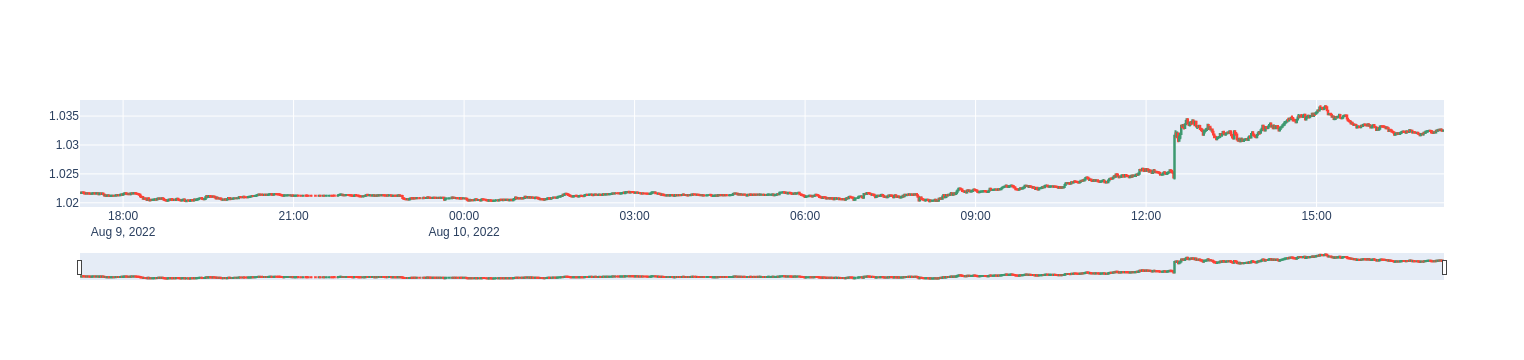

In [6]:
show_OHLC(df_ohlc)

# Aggregate Window

In [7]:
def candlestickData(range_start, range_stop, period, measurement):
    query_api = client.query_api()
    if measurement == "bid_open":
        aggfunc = "first"
    elif measurement == "bid_high":
        aggfunc = "max"
    elif measurement == "bid_low":
        aggfunc = "min"
    elif measurement == "bid_close":
        aggfunc = "last"
    
    query = f"""
            import "date"
            from(bucket: "DukascopyTest")
            |> range(start: {range_start}, stop: {range_stop})
            |> filter(fn: (r) => r._measurement == "{measurement}")
            |> filter(fn: (r) => r.symbol == "EUR/USD")
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
            |> map(fn: (r) => ({{r with _time: date.add(d: -1s, to: r._time)}}))
            |> aggregateWindow(column: "price", every: {period}, fn: {aggfunc})
            """
    
    tables = query_api.query(query, org=org)
    df = query_api.query_data_frame(query, org=org)
    return df

In [9]:
df = candlestickData("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z","5m", "bid_open")
display(df.iloc[0:20,[2,5,6]])
df = candlestickData("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z","5m", "bid_high")
display(df.iloc[0:20,[2,5,6]])
df = candlestickData("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z","5m", "bid_low")
display(df.iloc[0:20,[2,5,6]])
df = candlestickData("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z","5m", "bid_close")
display(df.iloc[0:20,[2,5,6]])


_measurement                     _time    price
0      bid_open 2022-08-09 17:15:00+00:00  1.02177
1      bid_open 2022-08-09 17:20:00+00:00  1.02169
2      bid_open 2022-08-09 17:25:00+00:00  1.02161
3      bid_open 2022-08-09 17:30:00+00:00  1.02158
4      bid_open 2022-08-09 17:35:00+00:00  1.02164
5      bid_open 2022-08-09 17:40:00+00:00  1.02158
6      bid_open 2022-08-09 17:45:00+00:00  1.02127
7      bid_open 2022-08-09 17:50:00+00:00  1.02120
8      bid_open 2022-08-09 17:55:00+00:00  1.02122
9      bid_open 2022-08-09 18:00:00+00:00  1.02133
10     bid_open 2022-08-09 18:05:00+00:00  1.02148
11     bid_open 2022-08-09 18:10:00+00:00  1.02151
12     bid_open 2022-08-09 18:15:00+00:00  1.02159
13     bid_open 2022-08-09 18:20:00+00:00  1.02151
14     bid_open 2022-08-09 18:25:00+00:00  1.02101
15     bid_open 2022-08-09 18:30:00+00:00  1.02049
16     bid_open 2022-08-09 18:35:00+00:00  1.02051
17     bid_open 2022-08-09 18:40:00+00:00  1.02056
18     bid_open 2022-08-09 18:45:00+00:00  1.02068
19     bid_open 2022-08-09 18:50:00+00:00  1.02037

_measurement                     _time    price
0      bid_high 2022-08-09 17:15:00+00:00  1.02177
1      bid_high 2022-08-09 17:20:00+00:00  1.02180
2      bid_high 2022-08-09 17:25:00+00:00  1.02170
3      bid_high 2022-08-09 17:30:00+00:00  1.02166
4      bid_high 2022-08-09 17:35:00+00:00  1.02166
5      bid_high 2022-08-09 17:40:00+00:00  1.02165
6      bid_high 2022-08-09 17:45:00+00:00  1.02135
7      bid_high 2022-08-09 17:50:00+00:00  1.02128
8      bid_high 2022-08-09 17:55:00+00:00  1.02139
9      bid_high 2022-08-09 18:00:00+00:00  1.02156
10     bid_high 2022-08-09 18:05:00+00:00  1.02171
11     bid_high 2022-08-09 18:10:00+00:00  1.02170
12     bid_high 2022-08-09 18:15:00+00:00  1.02171
13     bid_high 2022-08-09 18:20:00+00:00  1.02151
14     bid_high 2022-08-09 18:25:00+00:00  1.02101
15     bid_high 2022-08-09 18:30:00+00:00  1.02078
16     bid_high 2022-08-09 18:35:00+00:00  1.02066
17     bid_high 2022-08-09 18:40:00+00:00  1.02080
18     bid_high 2022-08-09 18:45:00+00:00  1.02079
19     bid_high 2022-08-09 18:50:00+00:00  1.02064

_measurement                     _time    price
0       bid_low 2022-08-09 17:15:00+00:00  1.02163
1       bid_low 2022-08-09 17:20:00+00:00  1.02160
2       bid_low 2022-08-09 17:25:00+00:00  1.02156
3       bid_low 2022-08-09 17:30:00+00:00  1.02156
4       bid_low 2022-08-09 17:35:00+00:00  1.02146
5       bid_low 2022-08-09 17:40:00+00:00  1.02123
6       bid_low 2022-08-09 17:45:00+00:00  1.02114
7       bid_low 2022-08-09 17:50:00+00:00  1.02115
8       bid_low 2022-08-09 17:55:00+00:00  1.02120
9       bid_low 2022-08-09 18:00:00+00:00  1.02131
10      bid_low 2022-08-09 18:05:00+00:00  1.02147
11      bid_low 2022-08-09 18:10:00+00:00  1.02147
12      bid_low 2022-08-09 18:15:00+00:00  1.02149
13      bid_low 2022-08-09 18:20:00+00:00  1.02098
14      bid_low 2022-08-09 18:25:00+00:00  1.02047
15      bid_low 2022-08-09 18:30:00+00:00  1.02037
16      bid_low 2022-08-09 18:35:00+00:00  1.02049
17      bid_low 2022-08-09 18:40:00+00:00  1.02050
18      bid_low 2022-08-09 18:45:00+00:00  1.02038
19      bid_low 2022-08-09 18:50:00+00:00  1.02033

_measurement                     _time    price
0     bid_close 2022-08-09 17:15:00+00:00  1.02168
1     bid_close 2022-08-09 17:20:00+00:00  1.02161
2     bid_close 2022-08-09 17:25:00+00:00  1.02157
3     bid_close 2022-08-09 17:30:00+00:00  1.02163
4     bid_close 2022-08-09 17:35:00+00:00  1.02159
5     bid_close 2022-08-09 17:40:00+00:00  1.02126
6     bid_close 2022-08-09 17:45:00+00:00  1.02120
7     bid_close 2022-08-09 17:50:00+00:00  1.02122
8     bid_close 2022-08-09 17:55:00+00:00  1.02133
9     bid_close 2022-08-09 18:00:00+00:00  1.02149
10    bid_close 2022-08-09 18:05:00+00:00  1.02149
11    bid_close 2022-08-09 18:10:00+00:00  1.02159
12    bid_close 2022-08-09 18:15:00+00:00  1.02154
13    bid_close 2022-08-09 18:20:00+00:00  1.02099
14    bid_close 2022-08-09 18:25:00+00:00  1.02048
15    bid_close 2022-08-09 18:30:00+00:00  1.02049
16    bid_close 2022-08-09 18:35:00+00:00  1.02053
17    bid_close 2022-08-09 18:40:00+00:00  1.02070
18    bid_close 2022-08-09 18:45:00+00:00  1.02038
19    bid_close 2022-08-09 18:50:00+00:00  1.02055

# Finding Fast & Slow Moving Average

In [10]:
def candlestickMovingAverage(range_start, range_stop, window_size=13, measurement="bid_close"):
    query_api = client.query_api()
    if measurement == "bid_open":
        aggfunc = "first"
    elif measurement == "bid_high":
        aggfunc = "max"
    elif measurement == "bid_low":
        aggfunc = "min"
    elif measurement == "bid_close":
        aggfunc = "last"
        
    query = f"""
            import "date"
            from(bucket: "DukascopyTest")
            |> range(start: {range_start}, stop: {range_stop})
            |> filter(fn: (r) => r._measurement == "{measurement}")
            |> filter(fn: (r) => r.symbol == "EUR/USD")
            |> movingAverage(n: {window_size})
            |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
            """
    
    tables = query_api.query(query, org=org)
    df = query_api.query_data_frame(query, org=org)
    return df

In [11]:
def get_trendscore(trend, time_start, time_stop, bid_type):
    df_fast = candlestickMovingAverage(time_start, time_stop, 13, bid_type)[81-13:].reset_index(drop=True)
    df_slow = candlestickMovingAverage(time_start, time_stop, 81, bid_type)

    df_diff = df_fast.price-df_slow.price
    df_diff = np.asarray(df_diff)
    df_diff = df_diff[1:]

    df_fast_slope=[]
    for i in range(1, len(df_fast)):
        df_fast_slope.append(df_fast.price[i]-df_fast.price[i-1]) 

    df_fast_slope = np.asarray(df_fast_slope)
    df_fast_slope_is_down = df_fast_slope < 0
    
    df_slow_slope=[]
    for i in range(1, len(df_slow)):
        df_slow_slope.append(df_slow.price[i]-df_slow.price[i-1]) 

    df_slow_slope = np.asarray(df_slow_slope)
    df_slow_slope_is_down = df_slow_slope < 0
   
    if trend == 'bearish':
        #Bearish
        df_TS_bear = (df_diff < 0) & df_fast_slope_is_down
        slow_start = []
        slow_end = []
        for i in range(1, len(df_TS_bear)):
            if df_TS_bear[i-1] and ~df_TS_bear[i]: #start
                slow_end.append(i-1)

            if ~df_TS_bear[i-1] and df_TS_bear[i]: #end
                slow_start.append(i-1)

        in_block = None
        bear_sum = []
        running_sum = 0

        length_box_list = []
        length_box = 0

        for idx, diff in enumerate(df_diff):
            if diff < 0 and df_TS_bear[idx]:
                in_block = True
                running_sum += 1
                bear_sum.append(running_sum)

                length_box += 1
                length_box_list.append(length_box)

            elif diff > 0:
                running_sum = 0
                length_box = 0
                bear_sum.append(running_sum)
                length_box_list.append(length_box)
            else:
                length_box += 1
                length_box_list.append(length_box)

                bear_sum.append(running_sum)
        bear_sum = np.asarray(bear_sum)   
        length_box_list = np.asarray(length_box_list)  
        trendscore = -(bear_sum * (bear_sum + 1)/2 + length_box_list)

        
    elif trend == 'bullish':
        #Bullish
        df_TS_bull = (df_diff > 0) & ~df_fast_slope_is_down
        slow_start = []
        slow_end = []
        for i in range(1, len(df_TS_bull)):
            if df_TS_bull[i-1] and ~df_TS_bull[i]: #start
                slow_end.append(i-1)

            if ~df_TS_bull[i-1] and df_TS_bull[i]: #end
                slow_start.append(i-1)

        in_block = None
        bull_sum = []
        running_sum = 0

        length_box_list = []
        length_box = 0

        for idx, diff in enumerate(df_diff):
            if diff > 0 and df_TS_bull[idx]:
                in_block = True
                running_sum += 1
                bull_sum.append(running_sum)

                length_box += 1
                length_box_list.append(length_box)

            elif diff < 0:
                running_sum = 0
                length_box = 0
                bull_sum.append(running_sum)
                length_box_list.append(length_box)
            else:
                length_box += 1
                length_box_list.append(length_box)

                bull_sum.append(running_sum)
        bull_sum = np.asarray(bull_sum)   
        length_box_list = np.asarray(length_box_list)  
        trendscore = (bull_sum * (bull_sum + 1)/2 + length_box_list)

    return trendscore

### Finding the boxes and TS for Bear

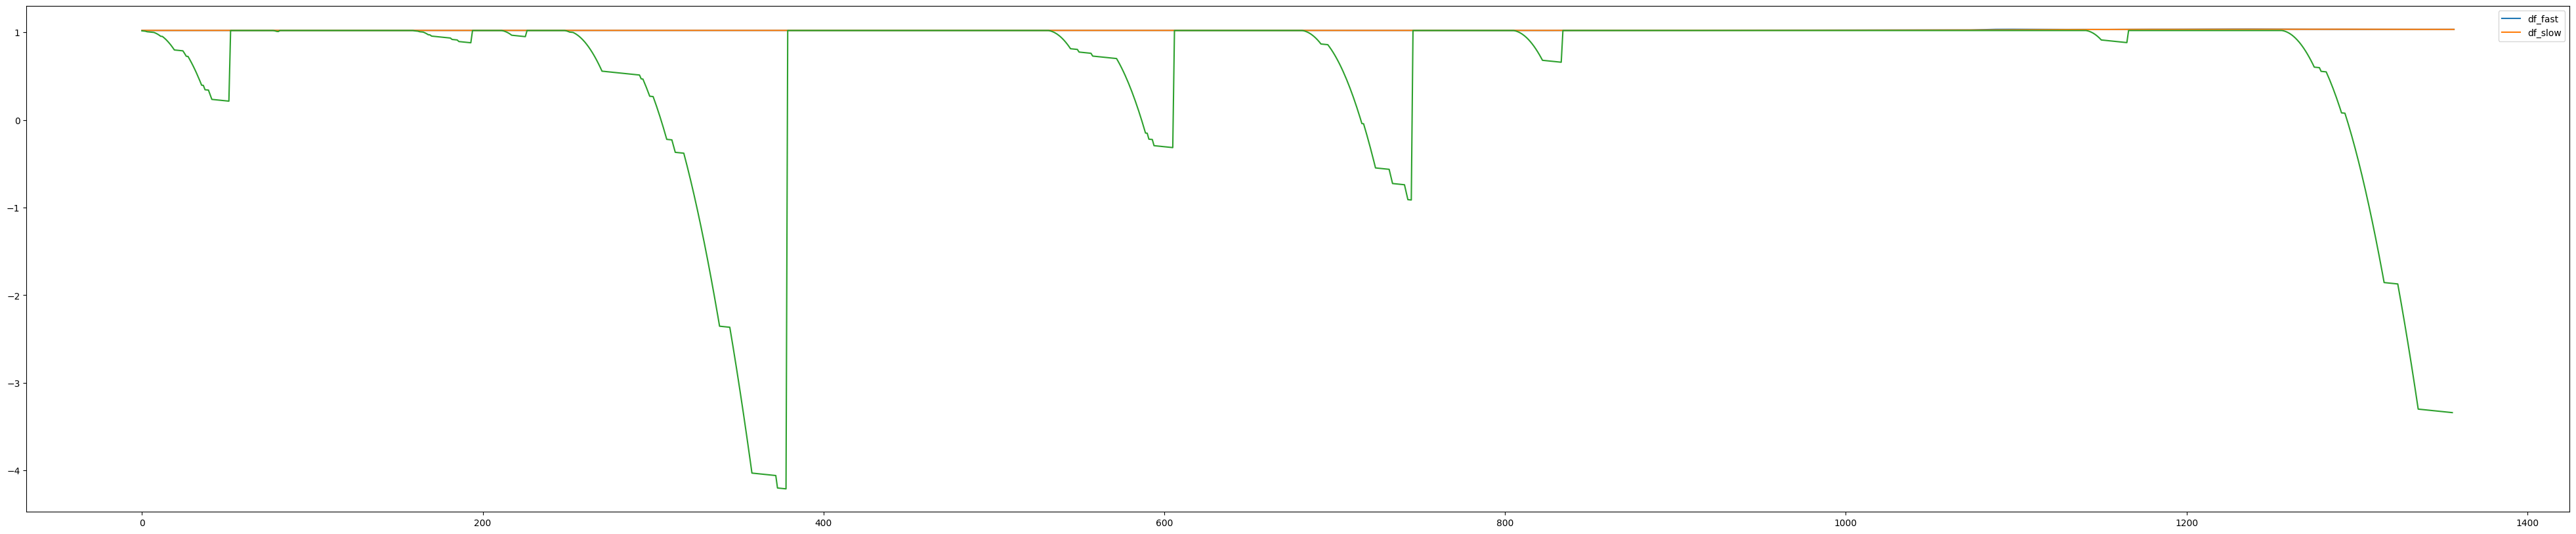

In [12]:
import matplotlib.pyplot as plt
df_fast = candlestickMovingAverage("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z",13, "bid_close")[81-13:].reset_index(drop=True)
df_slow = candlestickMovingAverage("2022-08-09T17:14:06.790Z","2022-08-10T17:14:06.790Z",81, "bid_close")
plt.figure(figsize=(50,10))
plt.plot(df_fast.price)
plt.plot(df_slow.price)


time_start = "2022-08-09T17:14:06.790Z"
time_stop = "2022-08-10T17:14:06.790Z"
bid_type = "bid_close"
df_TS_bear = get_trendscore('bearish', time_start, time_stop, bid_type)
plt.plot(df_TS_bear/500+1.020)
plt.legend(['df_fast', 'df_slow'])

### Finding the boxes and TS for Bull

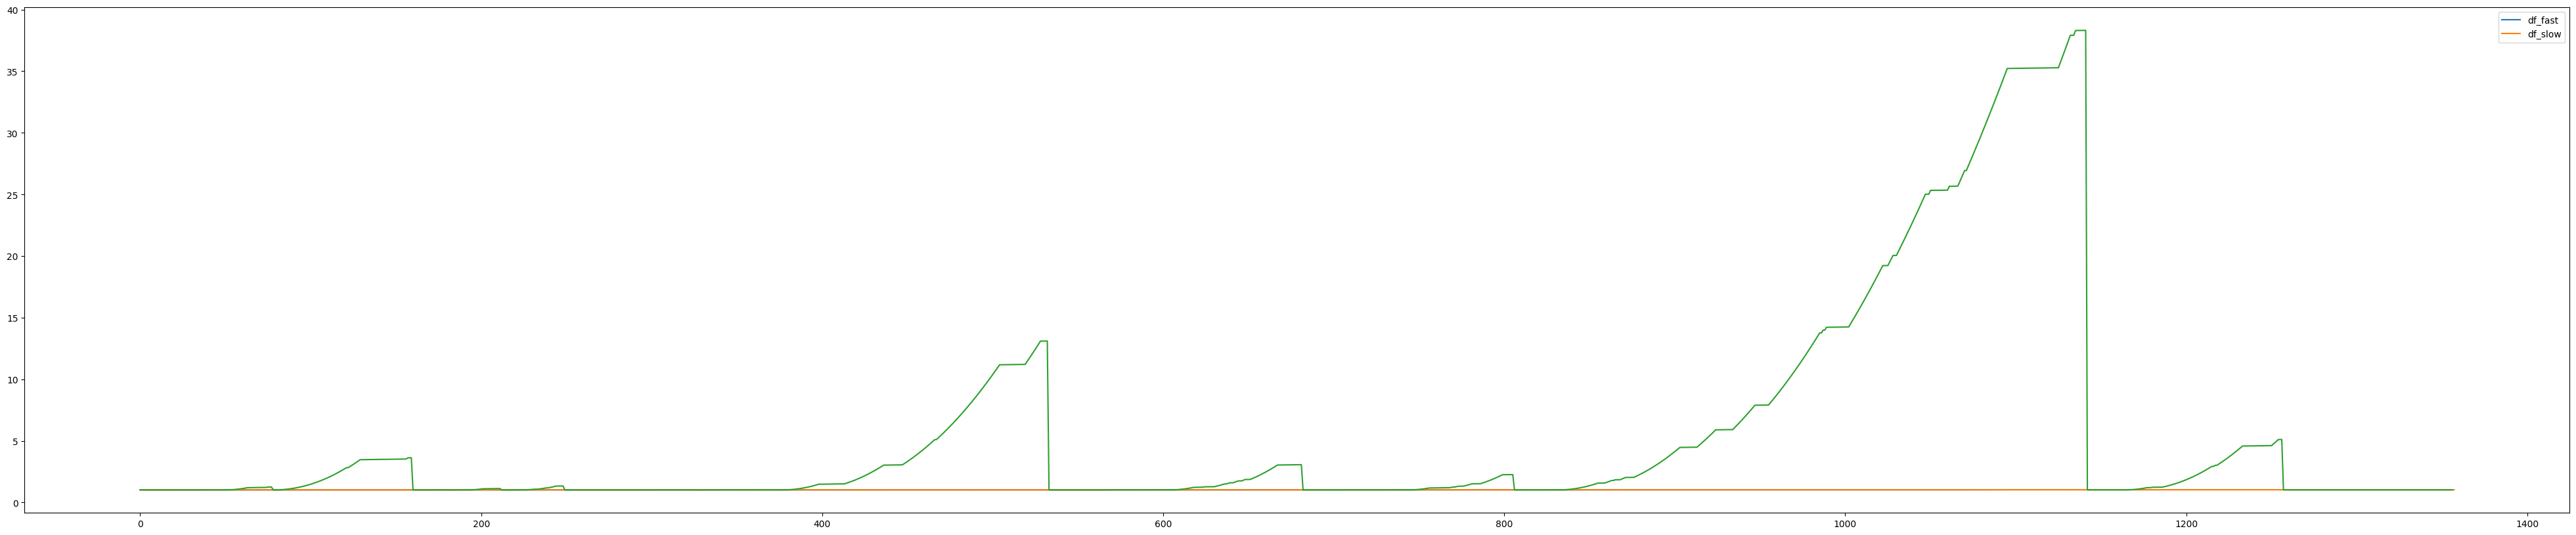

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,10))
plt.plot(df_fast.price)
plt.plot(df_slow.price)


time_start = "2022-08-09T17:14:06.790Z"
time_stop = "2022-08-10T17:14:06.790Z"
bid_type = "bid_close"
df_TS_bear = get_trendscore('bullish', time_start, time_stop, bid_type)
plt.plot(df_TS_bear/500+1.020)
plt.legend(['df_fast', 'df_slow'])